# THB/USD Exchange Rate Time Series Forecasting with LSTM

ในชุดข้อมูลประกอบด้วยข้อมูลที่มีความสัมพันธ์กับอัตราแลกเปลี่ยนสกุลเงินบาทกับดอลล่าห์สหรัฐ (THB/USD) ในแต่ละเดือนทั้งหมด 12 ปี

ข้อมูลประกอบด้วย
1. **date**: วันที่
2. **BAHT**: อัตราแลกเปลี่ยนสกุลเงินบาทกับดอลล่าห์สหรัฐ
3. **RMS_TH**: อัตราการเติบโตของปริมาณเงิน
4. **RINT_TH**: อัตราดอกเบี้ยแท้จริง
5. **RINT_IPI**: อัตราผลผลิต

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM

sns.set_theme(style="white", context="talk")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 300


## 1. Pre-processing

In [2]:
# นำเข้าไฟล์ข้อมูล
df = pd.read_csv('data/raw_data.csv',
                      parse_dates=['date'], index_col='date')
df.head(5)


,BAHT,RMS_TH,RINT_TH,RINT_IPI
date,,,,
2009-12-01,33.2322,NaN,0.39,NaN
2010-01-01,33.0353,-0.0002,0.19,-0.158353
2010-02-01,33.1491,0.0004,-0.05,-0.186851
2010-03-01,32.5077,-0.0013,0.32,-0.187540
2010-04-01,32.2877,0.0010,-0.41,-0.270556


In [3]:
# ลบข้อมูลที่มีค่า null ทิ้ง
df = df.dropna()
df.head(5)

,BAHT,RMS_TH,RINT_TH,RINT_IPI
date,,,,
2010-01-01,33.0353,-0.0002,0.19,-0.158353
2010-02-01,33.1491,0.0004,-0.05,-0.186851
2010-03-01,32.5077,-0.0013,0.32,-0.187540
2010-04-01,32.2877,0.0010,-0.41,-0.270556
2010-05-01,32.3946,0.0038,-0.07,-0.150433


In [4]:
# ดูประเภทของข้อมูลในแต่ละคอลัมน์
print(df.dtypes)
# ดูรายละเอียดของข้อมูล
df.describe()

BAHT        float64
RMS_TH      float64
RINT_TH     float64
RINT_IPI    float64
dtype: object


,BAHT,RMS_TH,RINT_TH,RINT_IPI
count,144.000000,144.000000,144.000000,144.000000
mean,32.220605,-0.000762,0.664653,0.036377
std,1.693304,0.003141,0.683263,0.112956
min,29.076500,-0.011600,-0.930000,-0.270556
25%,30.875900,-0.001900,0.185000,-0.033625
50%,31.989300,-0.000750,0.635000,0.026212
75%,33.051550,0.000600,1.132500,0.120109
max,36.161500,0.022200,2.400000,0.367855


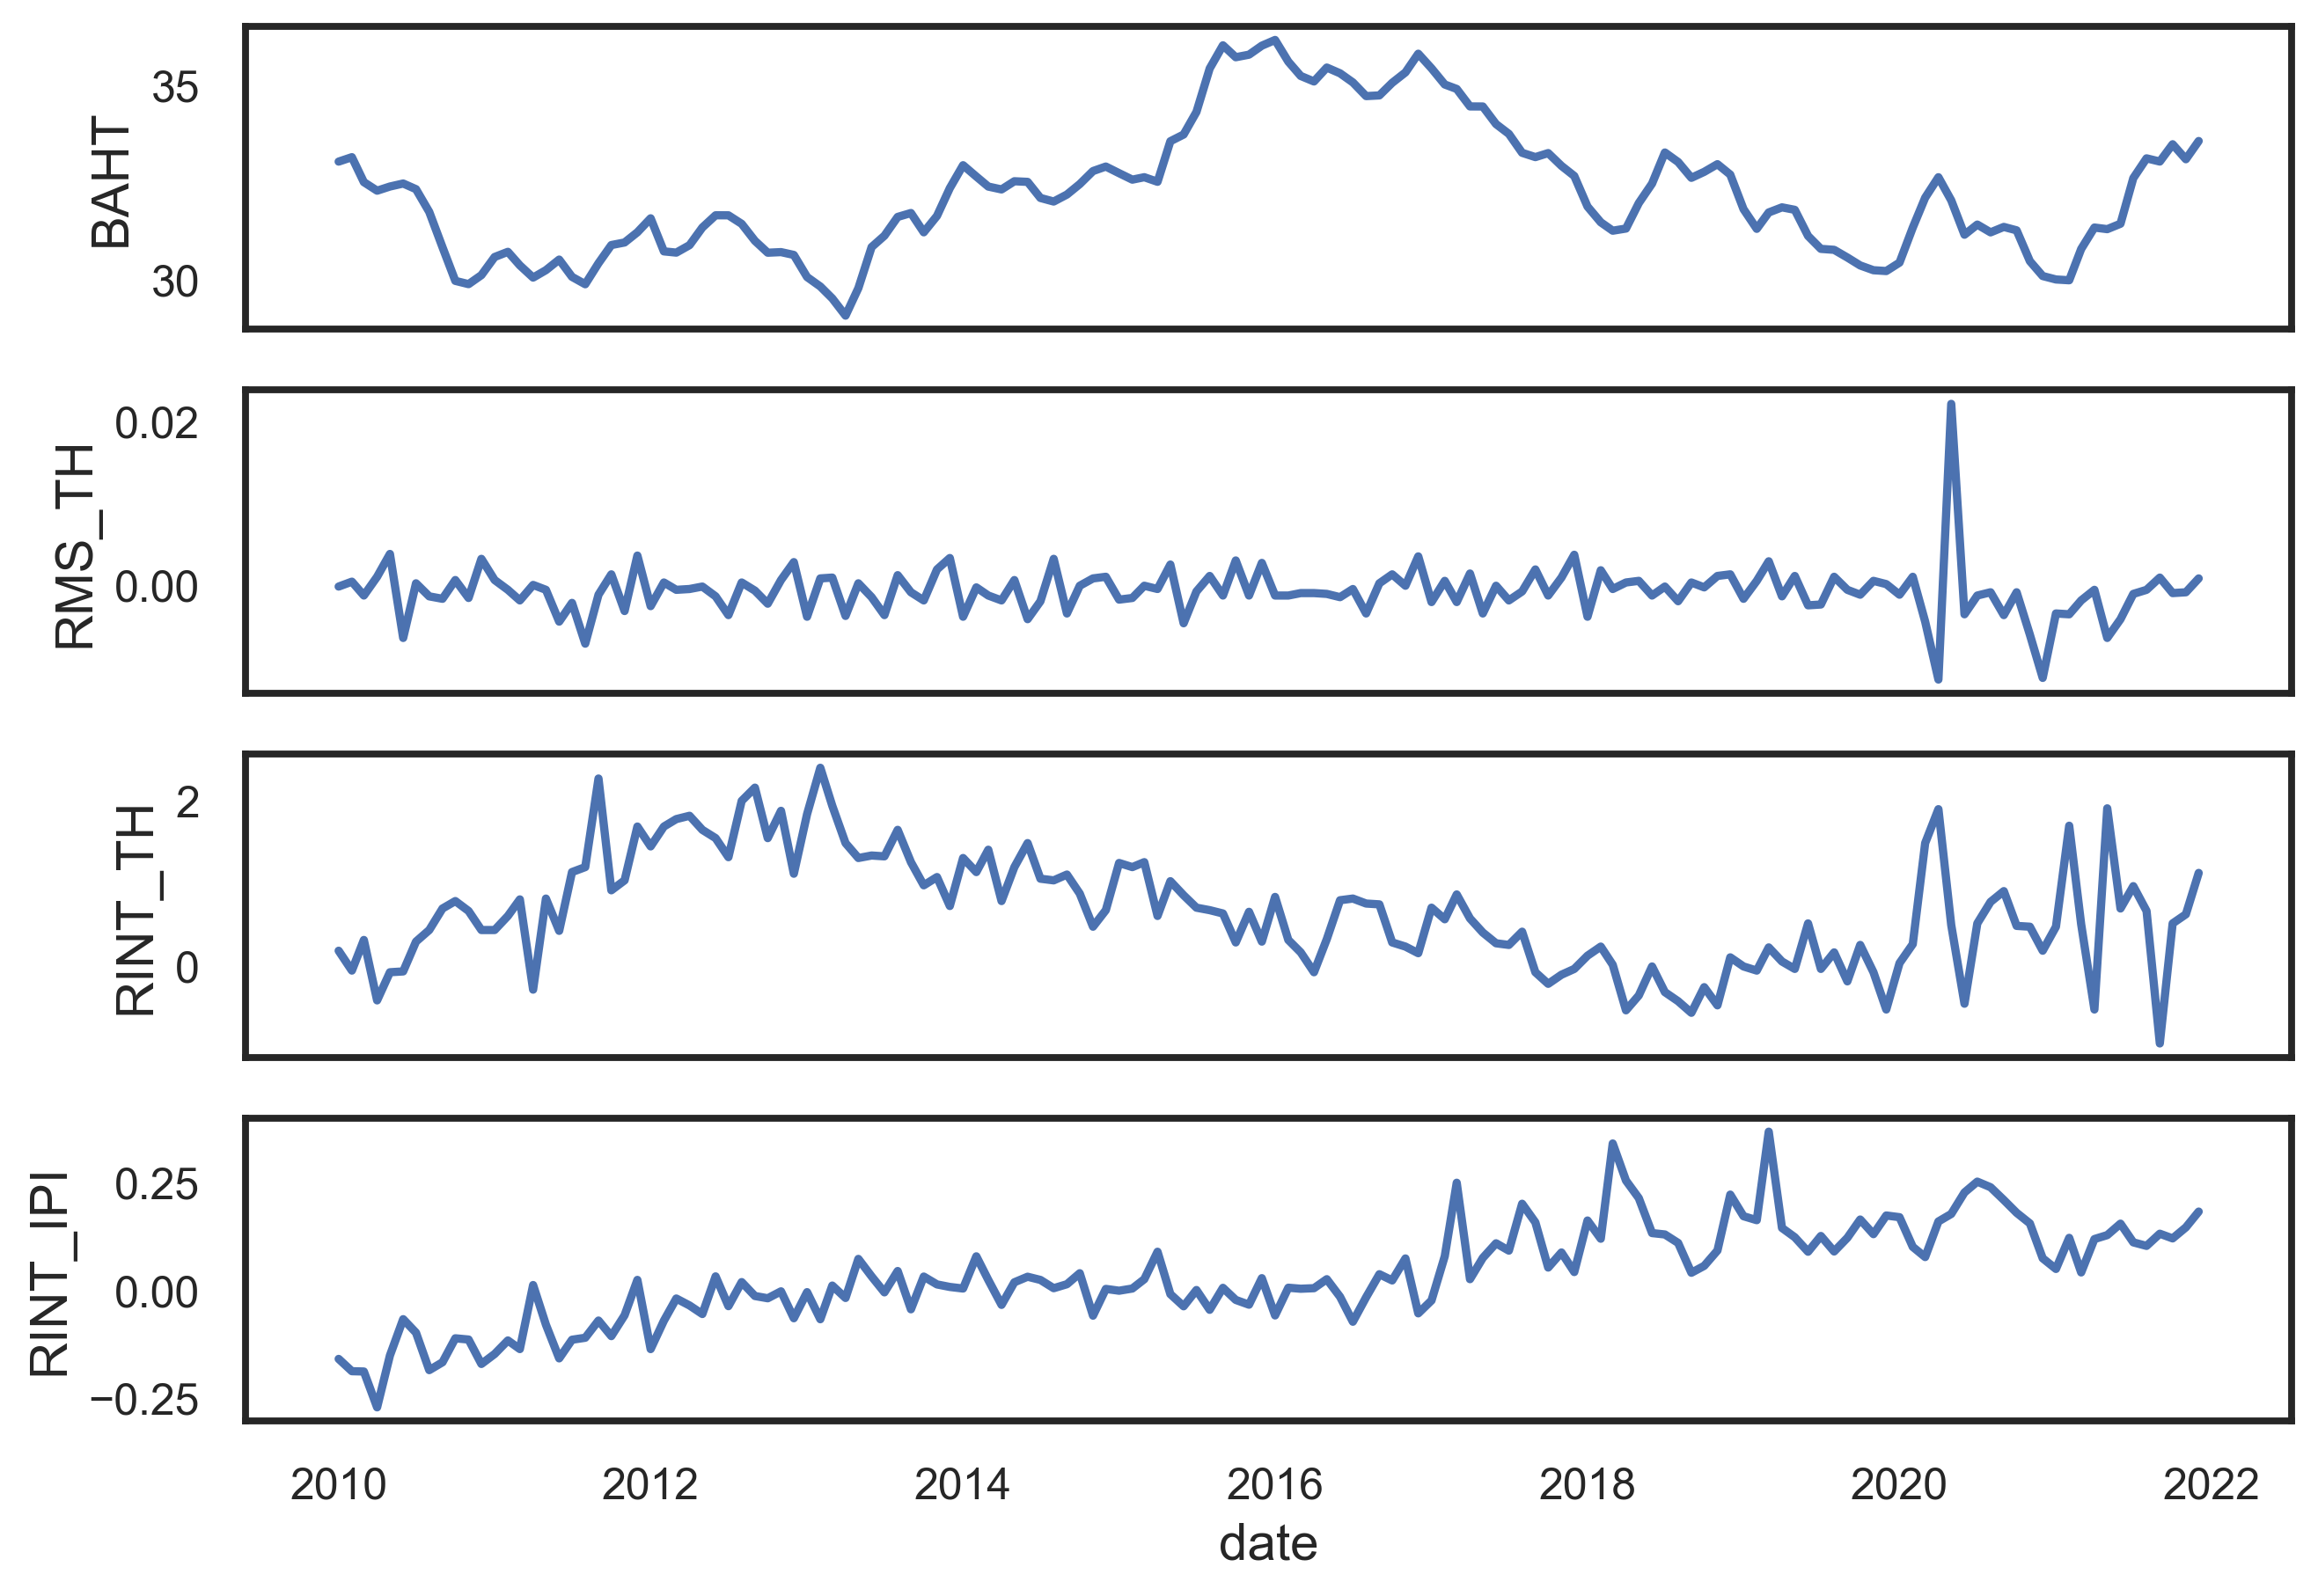

In [5]:
fig, ax = plt.subplots(nrows=4, sharex=True)
sns.lineplot(x='date', y='BAHT', data=df, ax=ax[0])
sns.lineplot(x='date', y='RMS_TH', data=df, ax=ax[1])
sns.lineplot(x='date', y='RINT_TH', data=df, ax=ax[2])
sns.lineplot(x='date', y='RINT_IPI', data=df, ax=ax[3])
plt.show()


In [6]:
# export ข้อมูลออก สำหรับนำไปใช้งานต่อ
df.to_csv('data/clean_data.csv')


## 2. Multivariate LSTM Forecast Model

### 2.1 LSTM Data Preparation

ในขั้นตอนแรกของการเตรียม dataset สำหรับ LSTM นั้นเราจะต้องทำการจัดเฟรมของ dataset ให้อยู่ในรูปของปัญหา Supervised Learning

วิธีการทำคือการจัดเฟรมของข้อมูลเพื่อทำนายอัตราแลกเปลี่ยนของสกุลเงิน (LBATH) ณ เดือนปัจจุบัน (t) โดยพิจารณาจากอัตราการเติบโตของปริมาณเงิน (RMS_TH) อัตราดอกเบี้ยแท้จริง (RINT_TH) และอัตราผลผลิต (RINT_IPI) ในเวลาก่อนหน้า


In [7]:
def timeseries_to_supervised(data, n_in=1, n_out=1, dropnan=True, feature_name=None):
    """
        Frame a time series as a supervised learning dataset.
        Arguments:
                data: Sequence of observations as a list or NumPy array.
                n_in: Number of lag observations as input (X).
                n_out: Number of observations as output (y).
                dropnan: Boolean whether or not to drop rows with NaN values.
                feature_name: List of feature names.
        Returns:
                Pandas DataFrame of series framed for supervised learning.
        """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feature_name[j]}(t-{i})' for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feature_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feature_name[j]}(t+{i})' for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN
    if dropnan:
        agg.dropna(inplace=True)
    return agg


หลังจากทำการแปลง dataset เราจะเห็นว่ามีชุดตัวแปรนำเข้าในเวลาก่อนหน้า และตัวแปรส่งออก (อัตราแลกเปลี่ยนของสกุลเงิน ณ เดือนปัจจุบัน)

In [8]:
from sklearn.preprocessing import MinMaxScaler

# ดึงข้อมูลสำหรับการเตรียม
df = pd.read_csv('data/clean_data.csv', header=0, index_col=0)
values = df.values

# ensure all data is float
# values = values.astype('float32')

# ทำการ normalize features ด้วย MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

# กำหนดค่า lag และ ahead
lag = 1
ahead = 1
reframed = timeseries_to_supervised(
    scaled, lag, ahead, feature_name=df.columns)
reframed.head()


,BAHT(t-1),RMS_TH(t-1),RINT_TH(t-1),RINT_IPI(t-1),BAHT(t),RMS_TH(t),RINT_TH(t),RINT_IPI(t)
1,0.117516,-0.325444,-0.327327,-0.648494,0.149640,-0.289941,-0.471471,-0.737772
2,0.149640,-0.289941,-0.471471,-0.737772,-0.031418,-0.390533,-0.249249,-0.739928
3,-0.031418,-0.390533,-0.249249,-0.739928,-0.093522,-0.254438,-0.687688,-1.000000
4,-0.093522,-0.254438,-0.687688,-1.000000,-0.063345,-0.088757,-0.483483,-0.623683
5,-0.063345,-0.088757,-0.483483,-0.623683,-0.041411,-0.698225,-0.477477,-0.360284


In [9]:
# drop คอลัมน์ที่ไม่ต้องการใช้ในการทำนาย
reframed.drop(['RMS_TH(t)', 'RINT_TH(t)', 'RINT_IPI(t)'], axis=1, inplace=True)
reframed.head()


,BAHT(t-1),RMS_TH(t-1),RINT_TH(t-1),RINT_IPI(t-1),BAHT(t)
1,0.117516,-0.325444,-0.327327,-0.648494,0.149640
2,0.149640,-0.289941,-0.471471,-0.737772,-0.031418
3,-0.031418,-0.390533,-0.249249,-0.739928,-0.093522
4,-0.093522,-0.254438,-0.687688,-1.000000,-0.063345
5,-0.063345,-0.088757,-0.483483,-0.623683,-0.041411


### 2.2 Train-Test Split

ในขั้นตอนนี้จะทำการแบ่งชุดข้อมูลเป็น 2 ชุดคือ train และ test จากนั้นจะแยกชุดข้อมูล train test ออกเป็นข้อมูลที่จะใช้ในการ input และ output ของแบบจำลอง
โดยแปลงค่าของชุดข้อมูลให้อยู่ในรูปแบบ 3 มิติ ซึ่งถูกแบ่งออกเป็น (samples, timesteps, features) เพื่อใช้ในแบบจำลอง LSTM

In [10]:
# กำหนด train / test โดยแบ่งเป็น train 90% และ test 10%
values = reframed.values
n_train = int(len(values) * 0.7)
train = values[:n_train, :]
test = values[n_train:, :]

# แบ่ง train / test ออกเป็น input และ outputs เพื่อใส่ในแบบจำลอง
X_train, y_train = train[:, :-ahead], train[:, -ahead:]
X_test, y_test = test[:, :-ahead], test[:, -ahead:]

# reshape ข้อมูล input ให้เป็น 3D (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], lag, int(X_train.shape[1]/lag))
X_test = X_test.reshape(X_test.shape[0], lag, int(X_test.shape[1]/lag))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(100, 1, 4) (100, 1) (43, 1, 4) (43, 1)


### 2.3 Grid Search

จากนั้นจะใช้ grid search ในการ tuning parameter เพื่อหาค่า epochs, hidden neurons และ batch size ที่ดีที่สุด

In [11]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor


In [18]:
def create_model(neurons=1):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(
        X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model


In [21]:
# create model
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the grid search parameters
neurons = [1, 5, 10, 15, 20, 25, 30]
epochs = [10, 50, 100, 200]
batch_size = [4, 8, 16, 32, 64, 128]
param_grid = dict(neurons=neurons, epochs=epochs, batch_size=batch_size)


In [22]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    n_jobs=1,
                    verbose=1)
grid_result = grid.fit(X_train, y_train)


Fitting 5 folds for each of 168 candidates, totalling 840 fits


In [23]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: -0.015572 using {'batch_size': 4, 'epochs': 200, 'neurons': 10}
-0.321001 (0.187769) with: {'batch_size': 4, 'epochs': 10, 'neurons': 1}
-0.178844 (0.100728) with: {'batch_size': 4, 'epochs': 10, 'neurons': 5}
-0.244212 (0.151761) with: {'batch_size': 4, 'epochs': 10, 'neurons': 10}
-0.210539 (0.118804) with: {'batch_size': 4, 'epochs': 10, 'neurons': 15}
-0.159644 (0.101775) with: {'batch_size': 4, 'epochs': 10, 'neurons': 20}
-0.125260 (0.072358) with: {'batch_size': 4, 'epochs': 10, 'neurons': 25}
-0.071852 (0.050330) with: {'batch_size': 4, 'epochs': 10, 'neurons': 30}
-0.178356 (0.144320) with: {'batch_size': 4, 'epochs': 50, 'neurons': 1}
-0.019338 (0.003076) with: {'batch_size': 4, 'epochs': 50, 'neurons': 5}
-0.017553 (0.003348) with: {'batch_size': 4, 'epochs': 50, 'neurons': 10}
-0.016064 (0.002516) with: {'batch_size': 4, 'epochs': 50, 'neurons': 15}
-0.016407 (0.003420) with: {'batch_size': 4, 'epochs': 50, 'neurons': 20}
-0.016000 (0.002839) with: {'batch_size': 4, '

### 2.4 Fit Model

จากนั้นทำการสร้างโมเดล LSTM โดยกำหนดให้ใน hidden layer มี 50 neuron และ output layer มี 1 neuron สำหรับการทำนายอัตราแลกเปลี่ยนของสกุลเงิน
สำหรับขนาดของข้อมูลนำเข้า (input shape) จะเป็น 1 time step จากชุดข้อมูลที่นำเข้า และมีฟีเจอร์จำนวน 4 ตัว

เราจะใช้ Mean Absolute Error (MAE) เป็น loss funtion และใช้ optimizer เป็น Adam เพื่อทำการอัพเดทข้อมูล

In [12]:
# กำหนด batch size กับ hidden neurons
n_batch = 8
n_neurons = 50

# สร้าง LSTM Network โดยใช้ library Keras
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(X_train.shape[1], X_train.shape[2]), stateful=False))
model.add(Dense(ahead))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


2022-06-04 16:36:34.178725: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


In [13]:
# ทำการ train แบบจำลอง โดยกำหนดให้ epochs = 50
history = model.fit(X_train, y_train, epochs=50, batch_size=n_batch, validation_data=(X_test, y_test), verbose=2, shuffle=False)


2022-06-04 16:36:35.455658: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
13/13 - 2s - loss: 0.2598 - val_loss: 0.1407
Epoch 2/50
13/13 - 0s - loss: 0.2353 - val_loss: 0.1339
Epoch 3/50
13/13 - 0s - loss: 0.2170 - val_loss: 0.1282
Epoch 4/50
13/13 - 0s - loss: 0.1999 - val_loss: 0.1229
Epoch 5/50
13/13 - 0s - loss: 0.1832 - val_loss: 0.1178
Epoch 6/50
13/13 - 0s - loss: 0.1668 - val_loss: 0.1128
Epoch 7/50
13/13 - 0s - loss: 0.1507 - val_loss: 0.1081
Epoch 8/50
13/13 - 0s - loss: 0.1349 - val_loss: 0.1034
Epoch 9/50
13/13 - 0s - loss: 0.1196 - val_loss: 0.0990
Epoch 10/50
13/13 - 0s - loss: 0.1049 - val_loss: 0.0948
Epoch 11/50
13/13 - 0s - loss: 0.0912 - val_loss: 0.0909
Epoch 12/50
13/13 - 0s - loss: 0.0785 - val_loss: 0.0871
Epoch 13/50
13/13 - 0s - loss: 0.0670 - val_loss: 0.0835
Epoch 14/50
13/13 - 0s - loss: 0.0570 - val_loss: 0.0800
Epoch 15/50
13/13 - 0s - loss: 0.0484 - val_loss: 0.0765
Epoch 16/50
13/13 - 0s - loss: 0.0411 - val_loss: 0.0729
Epoch 17/50
13/13 - 0s - loss: 0.0352 - val_loss: 0.0692
Epoch 18/50
13/13 - 0s - loss: 0.0304 - 

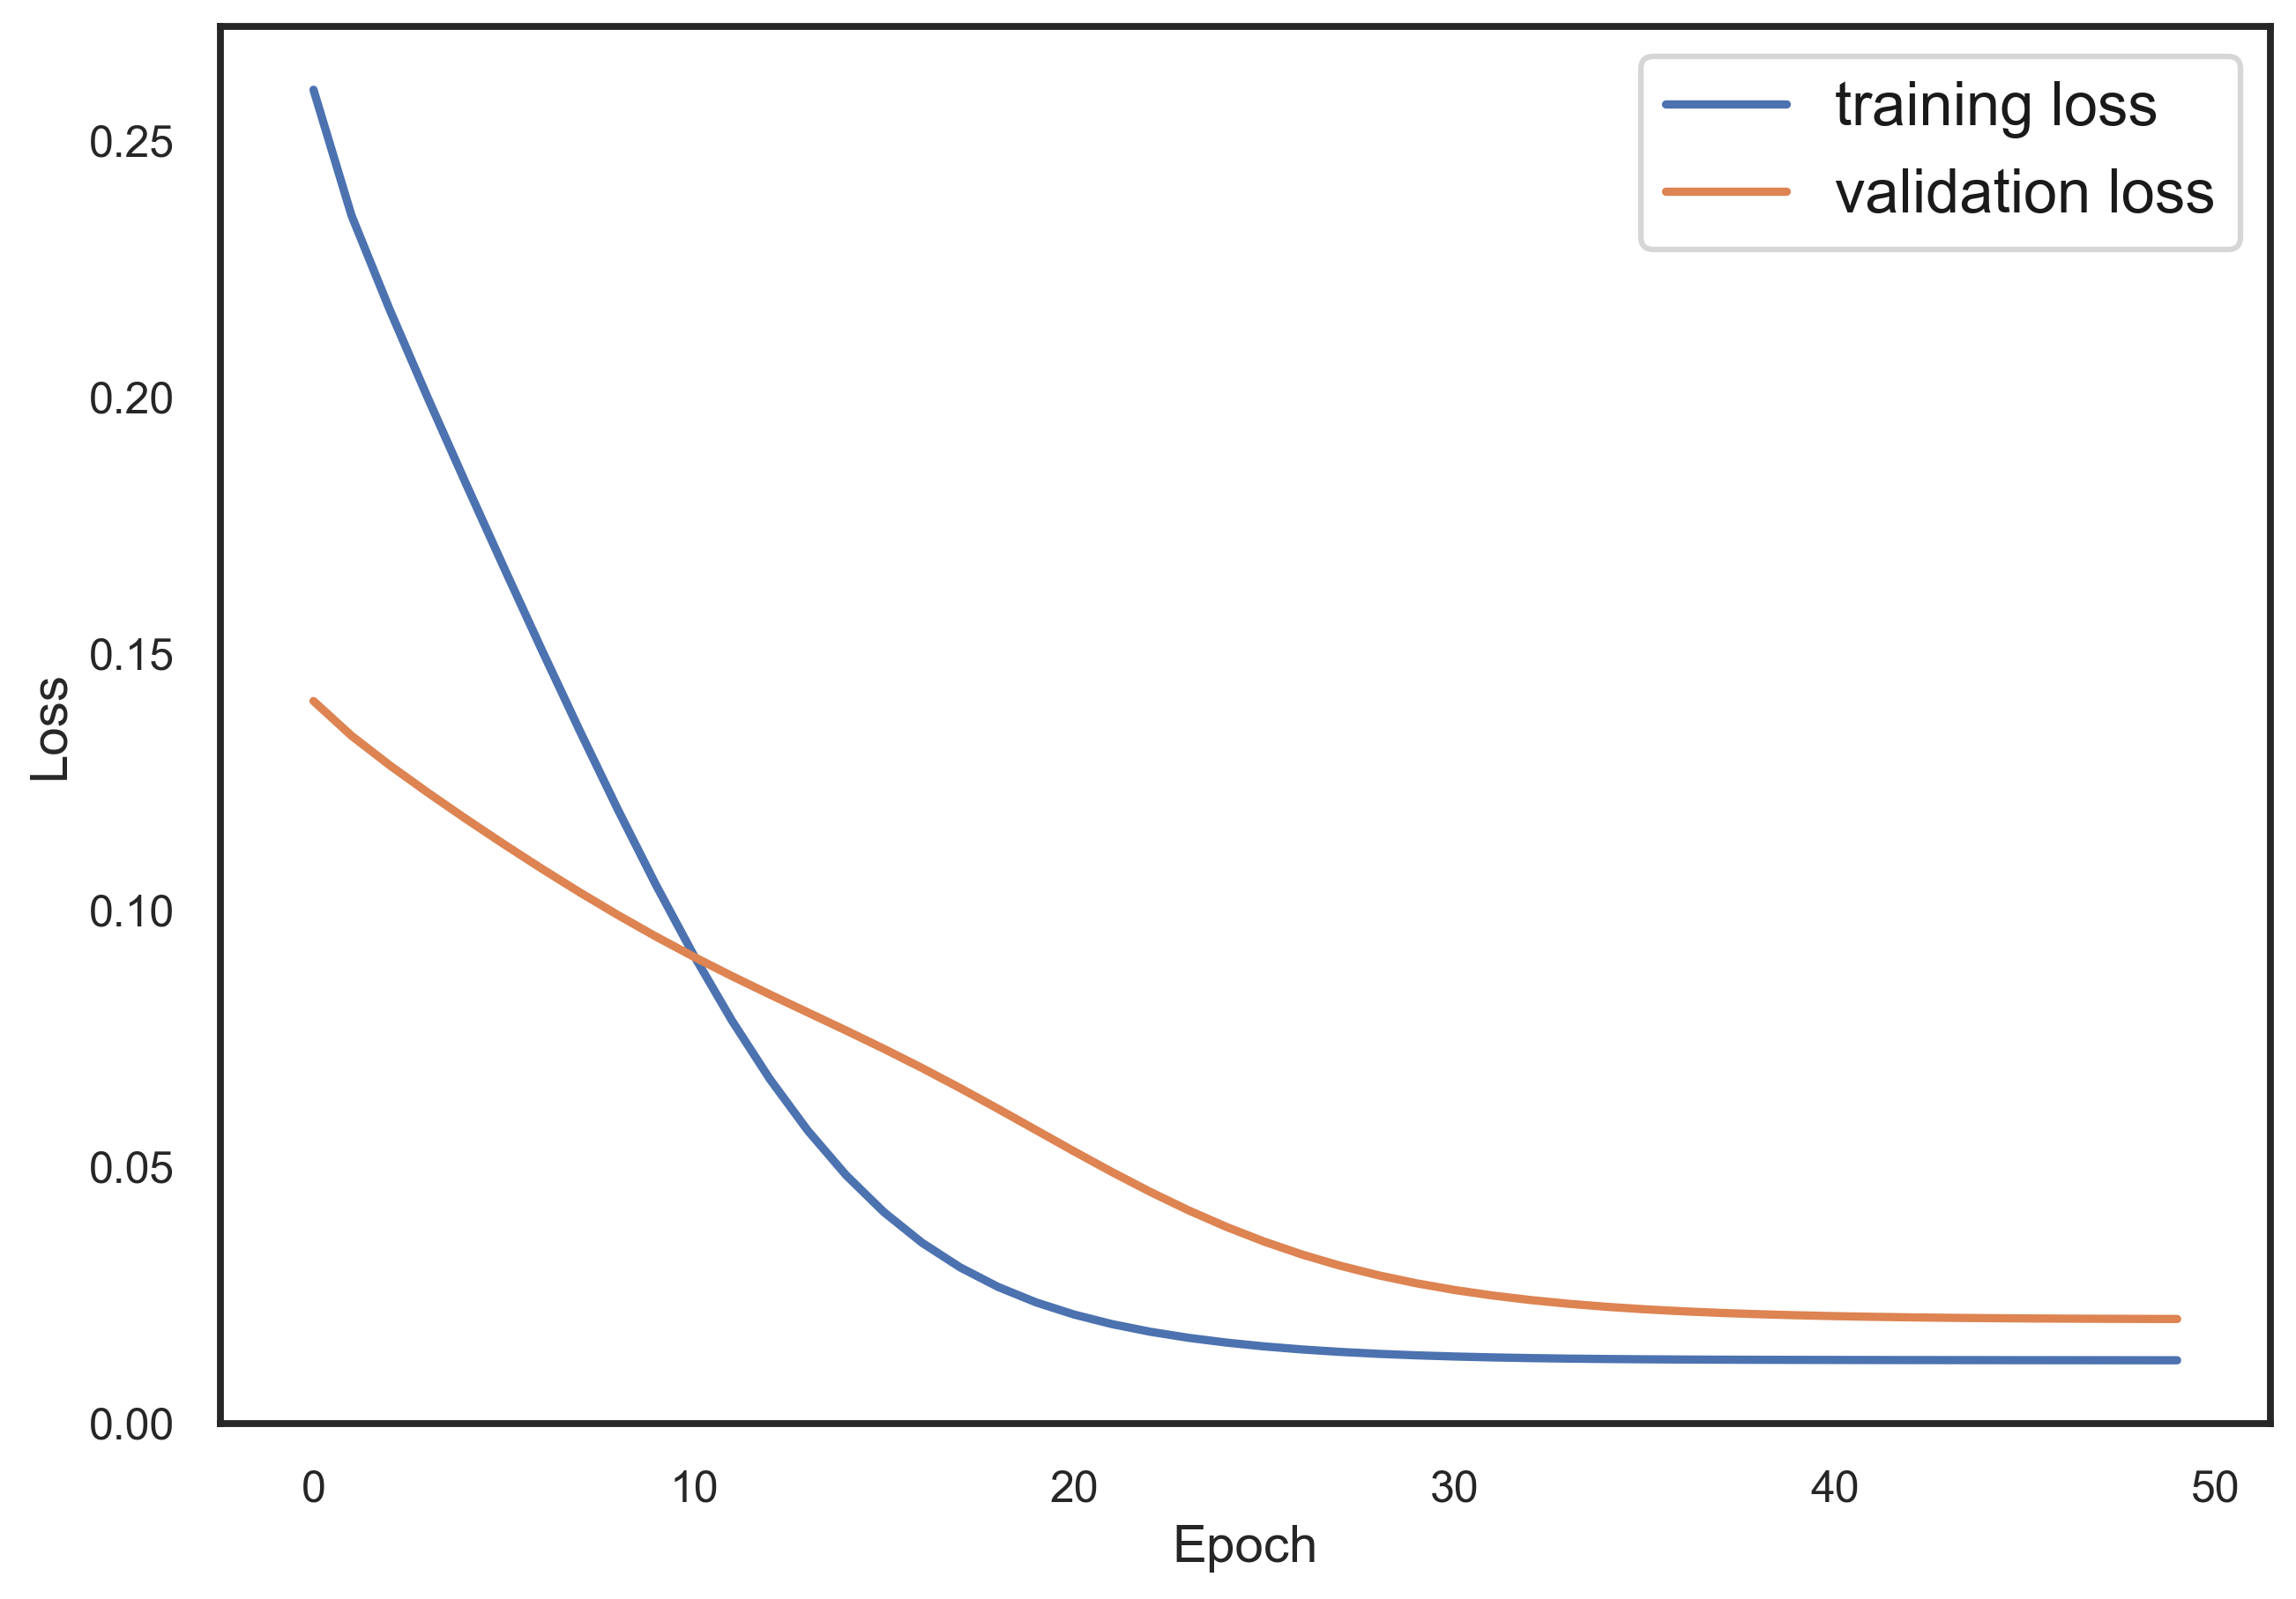

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


### 2.5 Evaluate Model

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import concatenate
from math import sqrt

# make a prediction
yhat = model.predict(X_test)
test_X = X_test.reshape((X_test.shape[0], -ahead))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -3:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = y_test.reshape((len(y_test), 1))
inv_y = concatenate((test_y, test_X[:, -3:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate Error
print('Test RMSE: %.4f' % sqrt(mean_squared_error(inv_y, inv_yhat)))
print('Test MSE: %.4f' % mean_squared_error(inv_y, inv_yhat))
print('Test MAE: %.4f' % mean_absolute_error(inv_y, inv_yhat))
print('Test MAPE: %.4f' % mean_absolute_percentage_error(inv_y, inv_yhat))
print('Test R2: %.4f' % r2_score(inv_y, inv_yhat))


Test RMSE: 0.5050
Test MSE: 0.2550
Test MAE: 0.4237
Test MAPE: 0.0134
Test R2: 0.7669


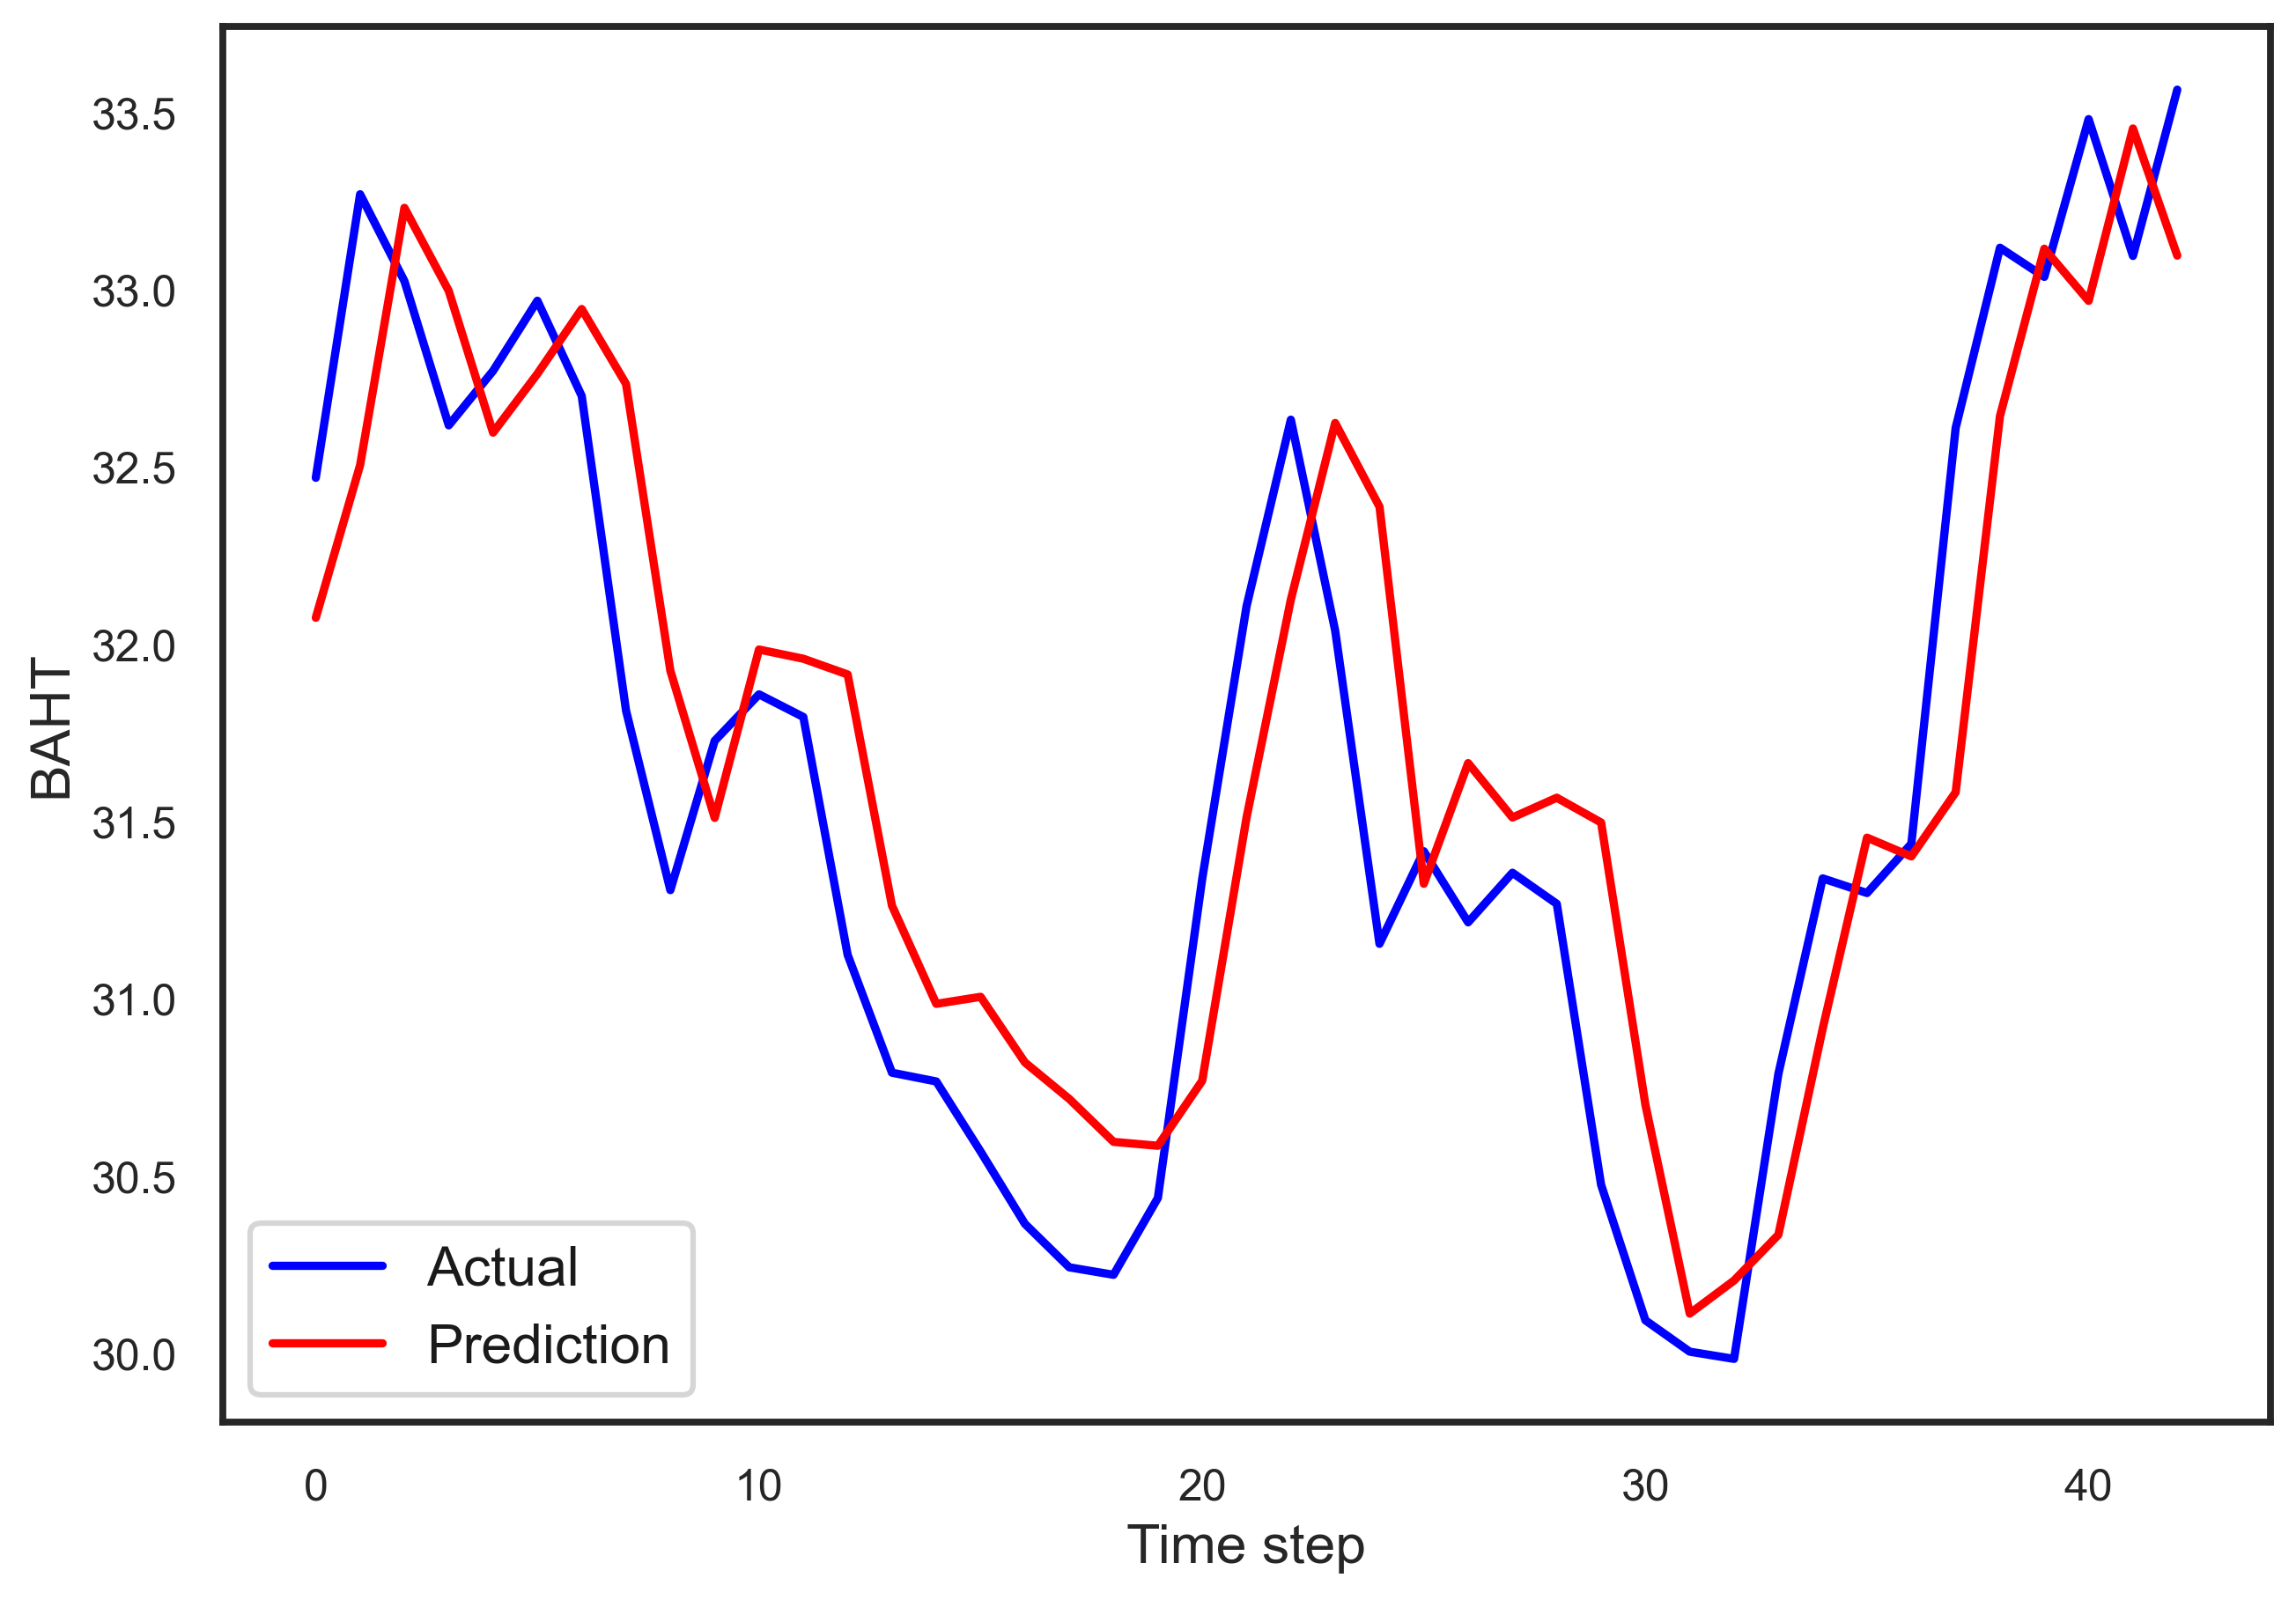

In [16]:
plt.plot(inv_y, label="Actual", color="blue")
plt.plot(inv_yhat, label="Prediction", color="red")
plt.ylabel('BAHT', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


In [17]:
reg_df = pd.DataFrame({'actual': inv_y, 'prediction': inv_yhat})
reg_df.head()

,actual,prediction
0,32.4702,32.075499
1,33.2698,32.505970
2,33.0248,33.231454
3,32.6181,32.997263
4,32.7718,32.597595


<AxesSubplot:xlabel='actual', ylabel='prediction'>

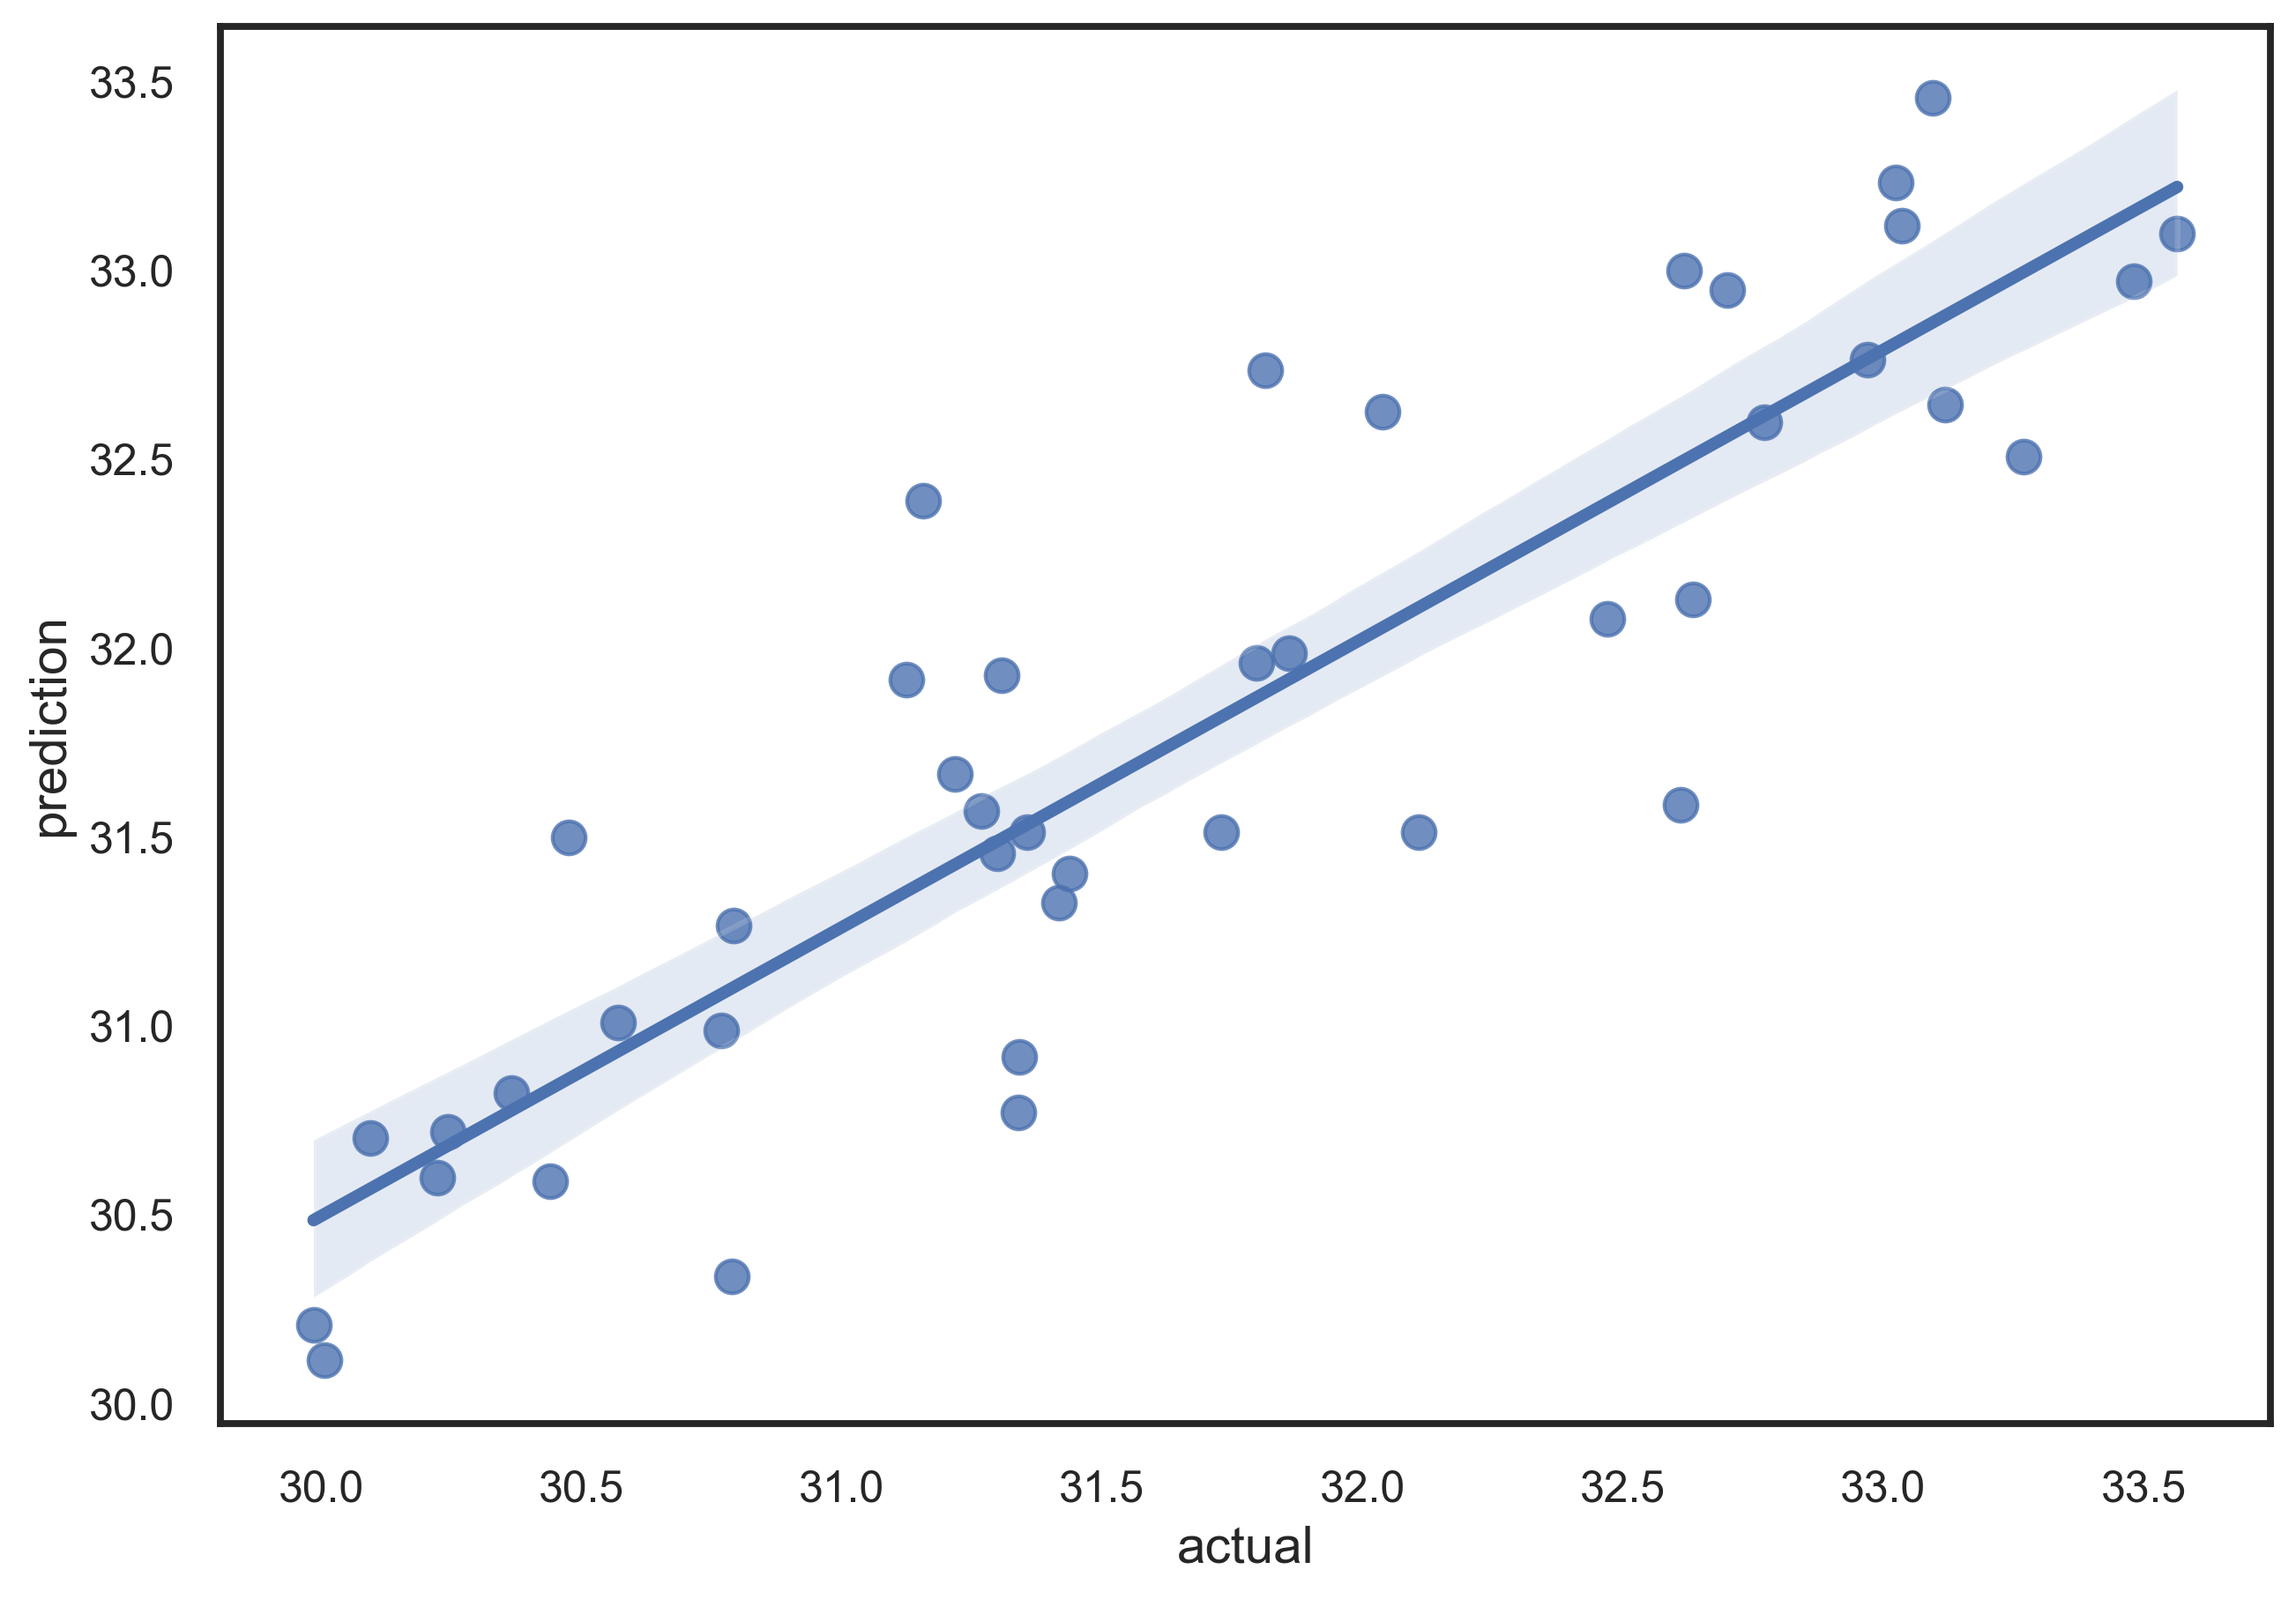

In [18]:
sns.regplot(x='actual', y='prediction', data=reg_df)
